# Dynamic time series clustering via volatility change-points

For more detailed discussion of the model and method see: 

XXXX

### The change-point model
$(T_n)_{n\geq0}$ is a sequence of integer-valued and strictly increasing change-point times. By convention $T_0=0$. 

Let $N_t = \max\{n\geq0 :T_n < t \}$ and $\tau_t=\max\{ (T_n)_{n\geq0} : T_n < t \}$ be respectively the number of change-points, and the time of the latest change-point, both strictly prior to $t$. 

Associated with each change-point $T_n$ is a triple of parameters $(\mu_n, \alpha_n, \sigma_n^2)$ and the observed returns $(y_t)_{t\geq0}$ are modelled:

\begin{equation}
y_{t} = \mu_{N(t)} + \alpha_{N(t)} y_{t-1}  + \sigma_{N(t)}\epsilon_t, \label{eq:like} 
\end{equation}

where $(\epsilon_t)_{t\geq1}$ are i.i.d. $\mathsf{N}(0,1)$.

### Prior distributions
The times between change-points are modelled as i.i.d. and negative-binomially distributed, 

\begin{equation}
T_n - T_{n-1}-1 \sim \mathsf{NegBin}(r,p),\quad k \geq 1.\label{eq:T_prior} 
\end{equation}

The parameter triples $(\mu_n, \alpha_n, \sigma_n^2)_{n\geq 0}$ are mutually independent, and independent of $(T_n)_{n\geq0}$,  with a zero-mean, normal-inverse-gamma prior on each triple: 

$$
p(\mu_{n},\alpha_{n},\sigma_{n}^{2})=\frac{1}{2\pi|V_{0}|^{1/2}}\frac{b^{a}}{\Gamma(a)}\left(\frac{1}{\sigma_{n}^{2}}\right)^{a+2}\exp\left(-\frac{2b+\beta_{n}^{\mathrm{T}}V_{0}^{-1}\beta_{n}}{2\sigma_{n}^{2}}\right),
$$

where $\beta_{n}=[\mu_{n}\;\alpha_{n}]^{\mathrm{T}}$, $V_{0}=\mathrm{diag(\delta_{0}^{2},\delta_{1}^{2})},$
and $a,b,\delta_{0},\delta_{1}$ are hyper-parameters which are common
across $n$.

Under this prior the parameter triples can be integrated out analytically, yielding closed-form expressions for the one-step-ahead predictive distribution and posterior distributions of the parameters associated with the most recent change-point, $(\mu_{N(t)},\alpha_{N(t)},\sigma_{N(t)}^2)$ conditional on the time of the most recent change-point:

\begin{align}
 & p(y_{t+1}|\tau_{t+1}=s,y_{s:t})=\mathsf{St}\left(2a_{s,t},h_{t+1}w_{s,t},\frac{b_{s,t}}{a_{s,t}}(1+h_{t+1}V_{s,t}h_{t+1}^{\mathrm{T}})\right),\label{eq:posterior_predictive}\\
 & p(\beta_{N(t)}|\tau_{t}=s,y_{s:t})=\mathsf{St}\left(2a_{s,t},w_{s,t},\frac{b_{s,t}}{a_{s,t}}V_{s,t}\right),\label{eq:parameter_posterior}\\
 & p(\sigma_{N(t)}^{2}|\tau_{t}=s,y_{s:t})=\mathsf{IG}(a_{s,t},b_{s,t}),\label{eq:sig^2_posterior}
\end{align}
where
\begin{align}
 & w_{s,t}= V_{s,t}H_{s,t}^{T}y_{s+1:t},\label{eq:posterior_mean}\\
 & V_{s,t}=(V_{0}^{-1}+H_{s,t}^{\mathrm{T}}H_{s,t})^{-1},\label{eq:posterior correlation}\\
 & a_{s,t}= a+\frac{t-s}{2},\label{eq:posterior shape}\\
 & b_{s,t}= b+\frac{1}{2}(\|y_{s+1:t}\|^{2}-w_{s,t}^{\mathrm{T}}V_{s,t}^{-1}w_{s,t}),\label{eq:posterior_scale}
 & H_{s,t}=[h_{t}^{\mathrm{T}}\cdots h_{s+1}^{\mathrm{T}}]^{\mathrm{T}},\\
 & h_{t}=[1\;y_{t-1}],\\
 &y_{s+1:t}\equiv[y_{t}\;y_{t-1}\;\cdots\;y_{s+1}]^{\mathrm{T}}.
\end{align}


Note that $\mathsf{St}\left(2a_{s,t},h_{t+1}w_{s,t},\frac{b_{s,t}}{a_{s,t}}(1+h_{t+1}V_{s,t}h_{t+1}^{\mathrm{T}})\right)$ is a univariate student's-$t$, the first argument is the degrees of freedom and the third argument is the squared scale parameter, whilst $\mathsf{St}\left(2a_{s,t},w_{s,t},\frac{b_{s,t}}{a_{s,t}}V_{s,t}\right)$ is a bivariate students-$t$ distribution with correlation matrix $\frac{b_{s,t}}{a_{s,t}}V_{s,t}$.

### Recursive inference for the most recent change-point
With $G$ denoting the common c.d.f. of the inter-change-point times $(T_n-T_{n-1})_{n\geq 1}$, the posterior distributions of the time of the most recent change-point:

\begin{equation}
\pi_{t}(s)=  p(\tau_{t}=s|y_{0:t}).\label{eq:filtering_distribution}
\end{equation}
with $\pi_{1}(0)=1$ satisfy:
\begin{equation}
\pi_{t+1}(s)\propto\begin{cases}
p(y_{t+1}|\tau_{t+1}=t,y_{0:t})\sum_{u=0}^{t-1}\left[\frac{G(t-u)-G(t-1-u)}{1-G(t-1-u)}\pi_{t}(u)\right], & s=t,\\
p(y_{t+1}|\tau_{t+1}=s,y_{0:t})\frac{1-G(t-s)}{1-G(t-1-s)}\pi_{t}(s), & s\in\{0,\ldots,t-1\},\\
0, & \mathrm{otherwise}.
\end{cases}\label{eq:recursion}
\end{equation}


In [1]:
%matplotlib notebook
%load_ext line_profiler

In [4]:
import numpy as np
from numpy import amax, amin, array, exp, eye, linspace, log, matmul, mean, outer, pi, std, sum, transpose
from numpy.linalg import det, inv
from scipy import stats
from scipy.special import gammaln
from scipy.stats import nbinom, invgamma
from scipy.stats import t as tDist

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

from IPython.display import clear_output

plt.rcParams['figure.figsize'] = [9,5] #globally set figure size
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.style.use('seaborn-whitegrid')

N = 100  #number of support points to maintain
pCred = 0.95  #size of posterior credible interval
 
df_prices = pd.read_csv('../data/SP500.csv', index_col=0, parse_dates=True)
df_clean = df_prices.dropna(axis=1)
df_returns = (df_clean/df_clean.shift(1)-1).dropna()
df_returns = (log(df_clean)-log(df_clean.shift(1))).dropna()

symb = 'chk' #stock symbol of interest to fit and do some plots - needs to be lower case
y = df_returns[symb].values
yPrice = df_prices[symb].values
datesRet = df_returns.index.values
n = df_returns.index.size

tb = np.arange(0, n, 1) #time base
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

#hyper-parameters
gam = 0.001 #b \equiv gam/2
nu = 0.001  #a \equiv gam/2
delta1 = 10
delta2 = 1/2
D = np.array([[delta1**2, 0],
              [0, delta2**2]])

#parameters for the prior transition probs
negBinR = 1
negBinP = 0.02  

    

### Eyeball the prices, retuns and plot autocorrelation...

<IPython.core.display.Javascript object>


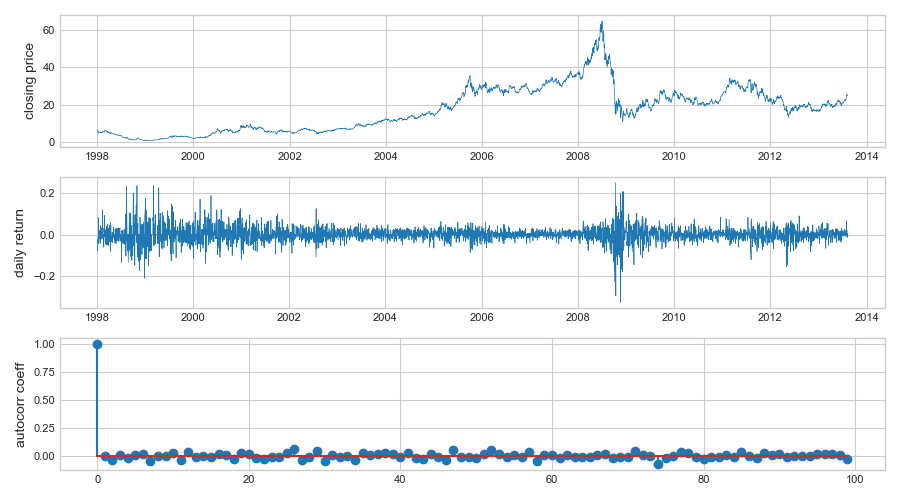

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

ax1.plot(df_prices[symb], linewidth = 0.5)
ax1.set_ylabel('closing price')

ax2.plot(df_returns[symb], linewidth = 0.5)
ax2.set_ylabel('daily return')

nlags = 100
acf = [pd.Series(df_returns[symb]).autocorr(lag) for lag in range(nlags)]
ax3.stem(acf)
ax3.set_ylabel('autocorr coeff')
ax3.grid(True)

fig.tight_layout()   
plt.show()  

### Eyeball a histrogram of returns and have a look at the tail behaviour...

<IPython.core.display.Javascript object>


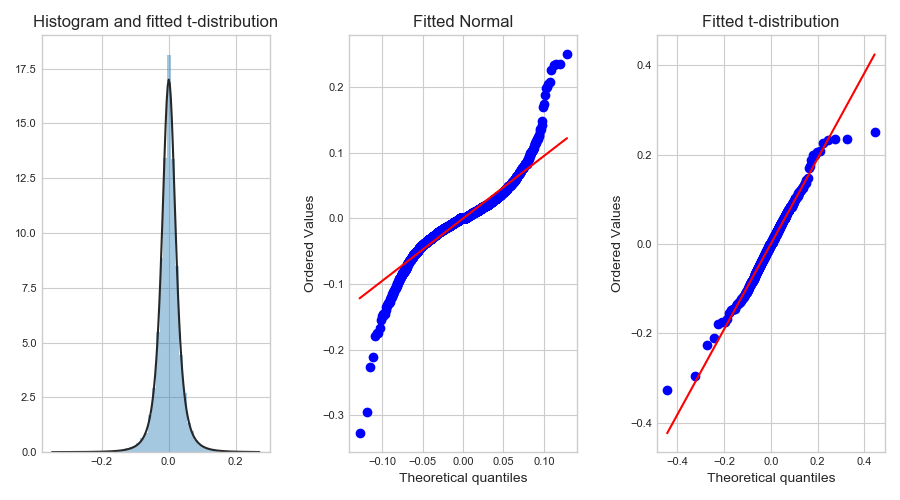

(2.8399606126391372, 0.0006093464095169793, 0.021525284000855828)


In [3]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ind = range(0,n)

mean_ret = mean(df_returns[symb].values[ind])
std_ret = std(df_returns[symb].values[ind])


[quantiles,fit] = stats.probplot(df_returns[symb], dist='norm', sparams = (mean_ret,std_ret), plot=ax2)
sns.distplot(df_returns[symb].values[ind], fit = stats.t, ax=ax1, kde=False)
sparams = stats.t.fit(df_returns[symb].values[ind])
[quantiles,fit] = stats.probplot( df_returns[symb].values[ind], plot=ax3, dist ='t', sparams = sparams )

ax1.set_title('Histogram and fitted t-distribution')
ax2.set_title('Fitted Normal')
ax3.set_title('Fitted t-distribution')

fig.tight_layout()  
plt.show()



### data type and functions for use when fitting the change-point model

In [8]:
#data type for sufficient statistics, incremental likelihoods etc associated with each particle
dt_ss = np.dtype([('logp', np.float64),
                  ('logw', np.float64),
                  ('M', np.float64, (2,2)),
                  ('ynormsq', np.float64),
                  ('ytil', np.float64, (2,)),
                  ('nuNow', np.float64),
                  ('gamNow', np.float64)])

#prior cdf of distance between two successive changepoints (which cannot be zero)
def G(t, negBinR, negBinP):
    g = nbinom.cdf(t,negBinR,negBinP) #params of neg bin are #trials > 0 and p \in (0,1)
    return g
               
    
#calculate p(s,s+1) and initializing the sufficient statistics. p(s,s+1) is likelihood of y_{s+1} give y_s and change-point at s
def NewSeg(gam, nu, D, h0, h1, yNow):     #evaluate likelihood contribution from new segment
    H = array([h0 , h1])                  #covariates
    M = inv(outer(H,H) + inv(D))
    ytil = H*yNow  #c.f. notes, transpose not needed here because of how matmul works
    ynormsq = yNow**2
    ynormPsq = ynormsq-matmul(ytil,matmul(M,ytil)) #n.b. matmul is insensitive to transpose of 1-D arguments
    gamNow = ynormPsq+gam
    nuNow = 1+nu
    logp = -0.5*log(np.pi) + 0.5*log(det(M)) - 0.5*log(det(D)) \
    + 0.5*nu*log(gam) \
    - 0.5*(1+nu)*log(ynormPsq+gam) \
    + gammaln(0.5*(1+nu)) \
    - gammaln(0.5*nu)
    logw = logp
    
    return logp, logw, M, ynormsq, ytil, nuNow, gamNow

#calculate p(s,t+1) for t>s and update the sufficient statistics. p(s,t+1) is likelihood of y_{s+1:t+1} given y_s and change-point at s
def UpdateSeg(s,t, gam, nu, D, h0, h1, yNow, logpOld, MOld, ynormsqOld,  ytilOld):
    h = array([h0, h1]) #c.f. notes, transpose not needed here because of how matmul works
    M = MOld - outer(matmul(MOld,h),matmul(h,MOld))/(1+matmul(h,matmul(MOld,h)))
    ytil = ytilOld + yNow*h
    ynormsq = ynormsqOld + yNow**2
    ynormPsq = ynormsq - matmul(ytil,matmul(M,ytil))
    gamNow = ynormPsq+gam
    nuNow = t+1-s+nu
    logp = -0.5*(t+1-s)*log(np.pi) + 0.5*log(det(M)) - 0.5*log(det(D)) \
    + 0.5*nu*log(gam) \
    - 0.5*(t+1-s+nu)*log(ynormPsq+gam) \
    + gammaln(0.5*(t+1-s+nu)) \
    - gammaln(0.5*nu)
    logw = logp - logpOld
    
    return logp, logw, M, ynormsq, ytil, nuNow, gamNow

#posterior predictive credible interval
def PostPredCred(h0, h1, nu, gam, beta, M, pCred):
    h = array([h0, h1])
    mu = matmul(h,beta)
    sig = (gam/nu * (1+matmul(h,matmul(M,h))))**0.5
    yCred = tDist.interval(pCred,nu,mu,sig) 
    
    return yCred, mu
   
 

### main routine that performs recursive inference and a pruning strategy to control cost

In [9]:
#initialize sufficient statistics, change-point times and filtering probs
eta = np.empty( [N+1, n], dtype=dt_ss )
cp = np.empty( [N+1, n], dtype=int )
logPr = np.empty( [N+1, n], dtype=float )  #logPr[s,t-2] \equiv log Pr(C_t = s | y_1:t), NB y_1 (=y[0]) is treated just as a covariate for y_2 (=y[1]

#estimates and posterior predictive interval
iMAP = np.empty( n, dtype=int )   #array for storing indices of the MAP most recent change-point
cpMAP = np.empty( n, dtype=int )  #array for storing timess of the MAP most recent c.p.
betaEst = np.zeros( [2, n], dtype=float )   #posterior mean for \beta_{N(t)} conditional on MAP most recent c.p.
muCI = np.zeros( [2, n], dtype=float )      #posterior credible interval for \mu_{N(t)} cond. on MAP most recent c.p.
alphaCI = np.zeros( [2, n], dtype=float )   #posterior credible interval for \alpha_{N(t)} cond. on MAP most recent c.p.
sigSqEst = np.zeros( n, dtype=float )       #posterior mode for \sigma_{N(t)}^2 cond. on MAP most recent c.p.
sigSqCI = np.zeros( [2, n], dtype=float )   #posterior credible interval "
yPred = np.zeros( [n, 2], dtype=float )     #posterior-preditive credible interval
yPredMu = np.zeros( n, dtype=float )        #posterior-predictive mean

#until the time step exceeds the number of particles, filtering is exact
cp[0,0] = 0 #change-point times c[s,t-1] = s for t=1,2,... where t is as in notes
eta[0,0] = NewSeg(gam, nu, D, 1, y[0], y[1]) #initialize sufficient statistics NB y[0] is just treated as a covariate for y[1], so effectively there are n-1 "observations"
logPr[0,0] = 0 #filterng probabilities -- by convention there is a change point at zero w.p.1, i.e. pr(C_1=0)=1

#initial point estimates, posterior and predictive credible intervals
iMAP[0] = 0
cpMAP[0] = 0
betaEst[:,1] = matmul(eta[0,0]['M'],eta[0,0]['ytil']) #posterior mean on the basis of obs up to y[1]
muCI[:,1] = tDist.interval(pCred,eta[0,0]['nuNow'],loc=betaEst[0,1],
                           scale=(eta[0,0]['gamNow']*eta[0,0]['M'][0,0]/eta[0,0]['nuNow'])**0.5)
alphaCI[:,1] = tDist.interval(pCred,eta[0,0]['nuNow'],loc=betaEst[1,1],
                              scale=(eta[0,0]['gamNow']*eta[0,0]['M'][1,1]/eta[0,0]['nuNow'])**0.5)
sigSqEst[1] = eta[0,0]['gamNow']/(eta[0,0]['nuNow']+2)#posterior mode
sigSqCI[:,1] = invgamma.interval(pCred,eta[0,0]['nuNow']/2,loc=0,scale=eta[0,0]['gamNow']/2)
[yPred[2,:], yPredMu[2]] = PostPredCred(1, y[1], #this is the credible interval for y[2]
                          eta[0,0]['nuNow'], eta[0,0]['gamNow'], 
                          betaEst[:,1], eta[0,0]['M'], pCred)


#filtering recursion 
for t in range(1,n-1):     #NB second argument to range is exclusive
    
    #for progress percentage
    clear_output(wait=True)

    #resampling/pruning code under construction
    if t > N: #pruning -- get the indices of the N particles with biggest weights (i.e. discard one particle with smallest)
        ind = np.argpartition(logPr[0:N+1,t-1], 1)[1:] #check !!! faster the other way?
        indNew = N #this +1 is the number of support points before pruning
        #ind = np.array(range(1,N+1)) #just keep the N most recent support points
        #indNew = N
    else: #..otherwise just keep everything and index particles by time
        ind = np.array(range(0,t))
        indNew = t
    
      
    #for the new change-point...
    cp[indNew,t] = t
    eta[indNew,t] = NewSeg(gam, nu, D, 1, y[t], y[t+1])
    tempAr = np.zeros(indNew)
    
    #evaluate prior transition probabilities
    a = ind[0:indNew]
    s = cp[a,t-1]
    Geval_s = G(t-s, negBinR, negBinP)
    Geval_s_1 = G(t-s-1, negBinR, negBinP)
    tempAr = log(Geval_s - Geval_s_1) - log(1-Geval_s_1) + logPr[a,t-1]    
    
    #for i in range(0,indNew):  #to accumulate prior contributions from older change points to new changepoint
    #    a = ind[i]  #the ancestor index
    #    s = cp[a,t-1]  #the change point time associated with that ancestor
    #    tempAr[i] = log((G(t-s, negBinR, negBinP)-G(t-s-1, negBinR, negBinP))/(1-G(t-s-1, negBinR, negBinP))) + logPr[a,t-1]
        
    tempArM = amax(tempAr)    
    logPr[indNew,t] = eta[indNew,t]['logw'] + log(sum(exp(tempAr-tempArM)))+tempArM
    
   
    for i in range(0,indNew):  #for older change-points...
        a = ind[i] #the ancestor index
        s = cp[a,t-1] #change point time associated with that ancestor
        cp[i,t] = s   #keep the change-point time
        eta[i,t] = UpdateSeg(s,t, gam, nu, D, 1, y[t], y[t+1],
                             eta[a,t-1]['logp'], eta[a,t-1]['M'], 
                             eta[a,t-1]['ynormsq'], 
                             eta[a,t-1]['ytil'])
        #logPr[i,t] = eta[i,t]['logw'] + log((1-G(t-s, negBinR, negBinP))/(1-G(t-s-1, negBinR, negBinP))) + logPr[a,t-1]
        logPr[i,t] = eta[i,t]['logw'] + log((1-Geval_s[i])/(1-Geval_s_1[i])) + logPr[a,t-1] #use pre-evaluated cdf for speed
    
    #find MAP most recent change-point and the associated parameter est on the basis of obs up to and including y[t+1]
    iMAP[t] = np.argmax(logPr[0:indNew+1,t])
    cpMAP[t] = cp[iMAP[t],t]
    
    #posterior point estimates and credible intervals for parameters based on MAP most recent change-point
    betaEst[:,t+1] = matmul(eta[iMAP[t],t]['M'],eta[iMAP[t],t]['ytil']) #posterior mean on the basis of obs up to y[t+1]
    muCI[:,t+1] = tDist.interval(pCred,eta[iMAP[t],t]['nuNow'],loc=betaEst[0,t+1],
                                 scale=(eta[iMAP[t],t]['gamNow']*eta[iMAP[t],t]['M'][0,0]/eta[iMAP[t],t]['nuNow'])**0.5)
    alphaCI[:,t+1] = tDist.interval(pCred,eta[iMAP[t],t]['nuNow'],loc=betaEst[1,t+1],
                                    scale=(eta[iMAP[t],t]['gamNow']*eta[iMAP[t],t]['M'][1,1]/eta[iMAP[t],t]['nuNow'])**0.5)
    sigSqEst[t+1] = eta[iMAP[t],t]['gamNow']/(eta[iMAP[t],t]['nuNow']+2) #posterior mode NB IG params are nu/2,gam/2
    sigSqCI[:,t+1] = invgamma.interval(pCred,eta[iMAP[t],t]['nuNow']/2,loc=0,scale=eta[iMAP[t],t]['gamNow']/2)
    
    #if there are data points yet to come, get the posterior predictive credible interval for the next y
    if t < n-2:
        [yPred[t+2,:], yPredMu[t+2]] = PostPredCred(1, y[t+1], 
                                  eta[iMAP[t],t]['nuNow'], eta[iMAP[t],t]['gamNow'], 
                                  betaEst[:,t+1], eta[iMAP[t],t]['M'], pCred)   
    
    #clip the weights to avoid under/overflow
    logPr[0:indNew,t] = np.minimum(logPr[0:indNew,t],1e+7)
    logPr[0:indNew,t] = np.maximum(logPr[0:indNew,t],-1e+7)
    
    #normalize the probabilities 
        logPrM = 0
    logPrS = log(sum(exp(logPr[0:indNew,t] -logPrM)))+logPrM
    logPr[0:indNew,t] = logPr[0:indNew,t] - logPrS
    
  
    print("progress:", np.round(t/(n-2) * 100, 2), "%")
    

    

progress: 100.0 %


### plot time to MAP most recent change-point, posterior point estimates and credible intervals

<IPython.core.display.Javascript object>


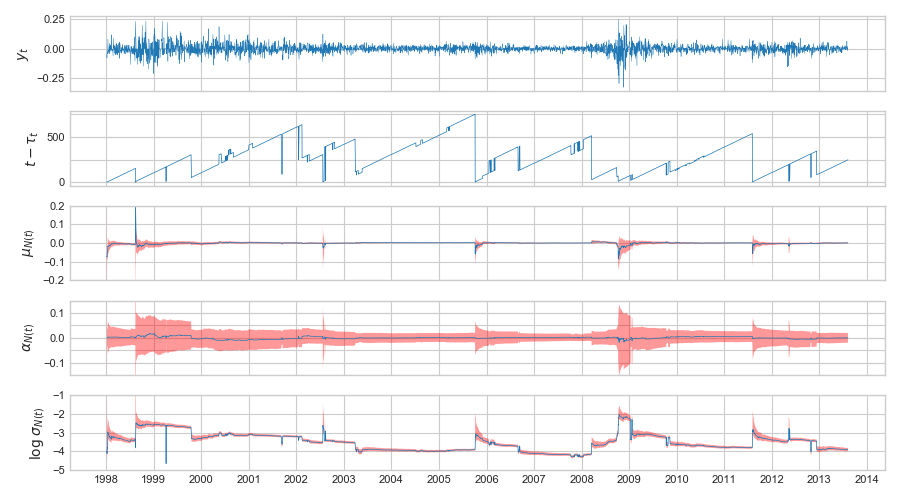

In [10]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)

tb = np.arange(0, n, 1) #time base

ax1.plot(df_returns[symb],linewidth=0.3)
ax2.plot(df_returns.index[1:n],tb[1:n]-cpMAP[0:n-1],linewidth=0.5)
ax3.plot(df_returns.index[1:n],betaEst[0 , 1:n],linewidth=0.5) 
ax3.fill_between(df_returns.index[1:n], muCI[0,1:n], muCI[1,1:n], alpha=0.4, facecolor = 'r')
ax4.plot(df_returns.index[1:n],betaEst[1 , 1:n],linewidth=0.5) #ar coefficient
ax4.fill_between(df_returns.index[1:n], alphaCI[0,1:n], alphaCI[1,1:n], alpha=0.4, facecolor = 'r')
ax5.plot(df_returns.index[1:n],log(sigSqEst[1:n]**0.5),linewidth=0.5)
ax5.fill_between(df_returns.index[1:n], log(sigSqCI[0,1:n]**0.5), log(sigSqCI[1,1:n]**0.5), alpha=0.4, facecolor = 'r')

ax1.set_ylabel(r'$y_t$')
ax2.set_ylabel(r'$t -  \tau_t $')        
ax3.set_ylabel(r'$\mu_{N(t)}$')
ax4.set_ylabel(r'$\alpha_{N(t)}$')
ax5.set_ylabel(r'$\log\; \sigma_{N(t)} $')

fig.tight_layout() 
plt.show()

In [11]:
#format plots
ax3.set_ylim([-0.2,0.2])
ax4.set_ylim([-0.15,0.15])
ax5.set_ylim([-5,-1])

ax5.xaxis.set_major_locator(years)
ax5.xaxis.set_major_formatter(yearsFmt)
ax5.xaxis.set_minor_locator(months)

tick_spacing = 0.1
ax3.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
tick_spacing = 0.1
ax4.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
tick_spacing = 1
ax5.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

minor_spacing = 250 
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(minor_spacing))
ax2.yaxis.grid(which="minor")

minor_spacing = 0.05 
ax4.yaxis.set_minor_locator(ticker.MultipleLocator(minor_spacing))
ax4.yaxis.grid(which="minor")



In [ ]:
plt.savefig('plots/params_'+ symb +'.pdf', Bbox='tight', pad_inches=0.1, format='pdf', dpi=1000)

### inspect a few of the posterior distributions of most recent change-points $\pi_t$

<IPython.core.display.Javascript object>


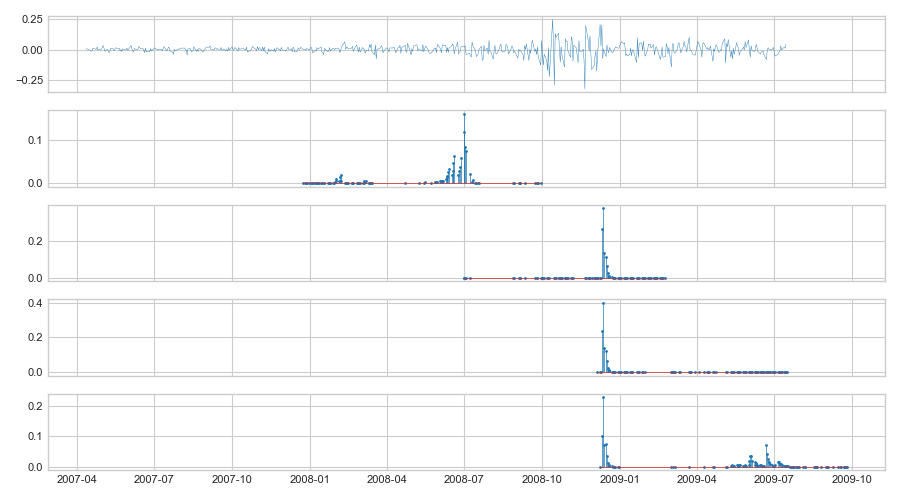

In [12]:
#plot a few change-point distributions
fig, ax = plt.subplots(5,1,sharex=True)

#t_plot = [400 , 500, 600, 700]
t_plot = [2700, 2800, 2900, 2950] #financial crisis
#t_plot = [2650, 2700, 2900, 3100] #apollo 2008
#t_plot = [1050, 1150, 1200, 1250] #amazon buys imdb
#t_plot = [2750, 3000, 3300, 3600] #coca cola

for i in range(0,4):
    cp_as_dates = datesRet[cp[0:np.minimum(t_plot[i],N)+1,t_plot[i]]]
    markerline, stemlines, baseline = ax[i+1].stem(cp_as_dates, 
                                               exp(logPr[0:np.minimum(t_plot[i],N)+1,t_plot[i]]))
    #ax[i].xaxis.set_tick_params(rotation=45)
    plt.setp(stemlines, 'linewidth', 0.5)
    plt.setp(markerline, 'markersize', 1)
    plt.setp(baseline, 'linewidth', 0.5)

plt.setp(stemlines, 'linewidth', 0.5)
plt.setp(markerline, 'markersize', 1)
plt.setp(baseline, 'linewidth', 0.5)

#ax[0].plot(df_returns.index[2200:2900],tb[2200:2900]-cpMAP[2199:2899],linewidth=0.5)
ax[0].plot(df_returns[symb][2330:2900],linewidth=0.3)

fig.tight_layout()
plt.show()

#print(datesRet[t_plot])


In [ ]:
plt.savefig('plots/cp_'+ symb +'.pdf', Bbox='tight', pad_inches=0.1, format='pdf', dpi=1000)
np.save('plots/cp_'+ symb + '.npy', t_plot)

### One-step-ahead posterior predictive distributions conditional on MAP most recent change-point

<IPython.core.display.Javascript object>


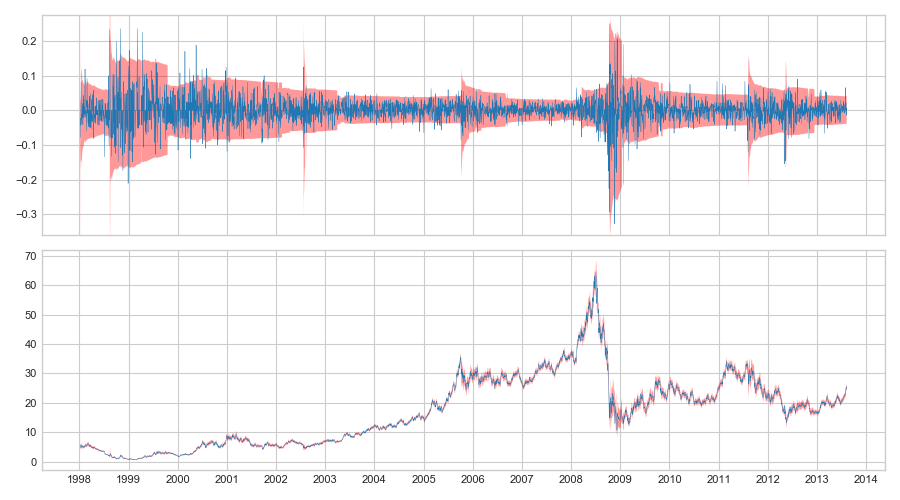

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(df_returns.index[2:n], y[2:n], linewidth=0.3)
#ax1.plot(df_returns.index[2:n], yPredMu[2:n], linewidth=0.5, color='w')
ax1.fill_between(df_returns.index[2:n], yPred[2:n,0], yPred[2:n,1], alpha=0.4, facecolor = 'r')
ax1.set_ylim([1.1*min(y[2:n]),1.1*max(y[2:n])])
#ax1.set_title('Returns and one-step-ahead posterior predictive credible interval', fontsize=8)

#push forward predictive credible interval in the case that return = (price_now-price_before)/price_before
#pricePred = yPredMu[2:n]*yPrice[1:n-1] + yPrice[1:n-1]
#pricePredL = yPred[2:n,0]*yPrice[1:n-1] + yPrice[1:n-1]
#pricePredU = yPred[2:n,1]*yPrice[1:n-1] + yPrice[1:n-1]

#or for the case return = log(price_now) - log_price(before)
pricePredL = yPrice[1:n-1]*exp(yPred[2:n,0]) 
pricePredU = yPrice[1:n-1]*exp(yPred[2:n,1])

ax2.plot(df_returns.index[2:n], yPrice[2:n], linewidth=0.3)
ax2.fill_between(df_returns.index[2:n], pricePredL, pricePredU, alpha=0.4, facecolor='r')
#ax2.set_title('Prices and one-step ahead posterior predictive credible interval', fontsize=8)

#ax2.set_ylim([0,320])
ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(months)

fig.tight_layout()
plt.show()

In [ ]:
plt.savefig('plots/predictive_'+ symb +'.pdf', Bbox='tight', pad_inches=0.1, format='pdf', dpi=1000)

In [ ]:
#find predictive credible intervals at given coverage probabilities and find proportion of observations which fall outside predictive credible interval
pCredMulti = np.concatenate((np.arange(0.5,1,0.025), np.array([0.99])))
numPCreds = pCredMulti.size
out_of_sample = np.zeros(numPCreds)

for i in range(0,numPCreds):
    for t in range(2,n):
        [yPred[t,:], yPredMu[t]] = PostPredCred(1, y[t-1], 
                                  eta[iMAP[t-2],t-2]['nuNow'], eta[iMAP[t-2],t-2]['gamNow'], 
                                  betaEst[:,t-2], eta[iMAP[t-2],t-2]['M'], pCredMulti[i]) 
        if y[t] > yPred[t,1] or y[t] < yPred[t,0]:
            out_of_sample[i] = out_of_sample[i] + 1
                                           
pCredMulti_Emp = 1 - out_of_sample/(n-2)



In [ ]:
print(pCredMulti_Emp)
np.save('plots/coverage_'+ symb + '.npy', pCredMulti_Emp)

In [ ]:
#plot the proportions of returns falling with credible intervals of given coverage probabilities
fig, ax = plt.subplots()
ax.scatter(100*pCredMulti, 100*pCredMulti_Emp)
ax.plot([50, 100], [50,100], color='r', linewidth=0.5)
ax.set_aspect(aspect=1)

ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.grid(which="minor")
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.xaxis.grid(which="minor")
ax.set_title('% of returns falling within % posterior predictive credible interval', fontsize=8)

fig.tight_layout()
plt.show()


## main routine as a function to be called across symbols

calculation of credible intervals and some other non-essential details left out for speed.

In [ ]:
def runModel(y, n):
    #initialize sufficient statistics, change-point times and filtering probs
    eta = np.empty( [N+1, n], dtype=dt_ss )
    cp = np.empty( [N+1, n], dtype=int )
    logPr = np.empty( [N+1, n], dtype=float )  #logPr[s,t-2] \equiv log Pr(C_t = s | y_1:t), NB y_1 (=y[0]) is treated just as a covariate for y_2 (=y[1]

    #estimates and posterior predictive interval
    cpMAP = np.empty( n, dtype=int )
    betaEst = np.zeros( [2, n], dtype=float )
    yPred = np.zeros( [n, 2], dtype=float )
    yPredMu = np.zeros( n, dtype=float )

    #until the time step exceeds the number of particles, filtering is exact
    cp[0,0] = 0 #change-point times c[s,t-1] = s for t=1,2,... where t is as in notes
    eta[0,0] = NewSeg(gam, nu, D, 1, y[0], y[1]) #initialize sufficient statistics
    logPr[0,0] = 0 #filterng probabilities -- by convention there is a change point at zero w.p.1, i.e. pr(C_1=0)=1

    cpMAP[0] = 0
    betaEst[:,1] = matmul(eta[0,0]['M'],eta[0,0]['ytil'])
    [yPred[2,:], yPredMu[2]] = PostPredCred(1, y[1], #this is the credible interval for y[2]
                          eta[0,0]['nuNow'], eta[0,0]['gamNow'], 
                          betaEst[:,1], eta[0,0]['M'], pCred)


    #filtering recursion - here index t has same interpretation as in notes
    for t in range(1,n-1):     #NB second argument to range is exclusive
    
        #for progress percentage
        clear_output(wait=True)

        #resampling/pruning code under construction
        if t > N: #pruning -- get the indices of the N particles with biggest weights (i.e. discard one particle with smallest)
            ind = np.argpartition(logPr[0:N+1,t-1], 1)[1:] #check !!! faster the other way?
            indNew = N #this +1 is the number of support points before pruning
        
        else: #..otherwise just keep everything and index particles by time
            ind = np.array(range(0,t))
            indNew = t
           
        #for the new change-point...
        cp[indNew,t] = t
        eta[indNew,t] = NewSeg(gam, nu, D, 1, y[t], y[t+1])
        tempAr = np.zeros(indNew)
        
        #vectorized version of for below - NB cdf evaluation in G() can be slow
        a = ind[0:indNew]
        s = cp[a,t-1]
        Geval_s = G(t-s, negBinR, negBinP)
        Geval_s_1 = G(t-s-1, negBinR, negBinP)
        #tempAr = log((Geval_s - Geval_s_1)/Geval_s_1) + logPr[a,t-1]
        tempAr = log(Geval_s - Geval_s_1) - log(1-Geval_s_1) + logPr[a,t-1]    
    
        #for i in range(0,indNew):  #to accumulate prior contributions from older change points to new changepoint
        #    a = ind[i]  #the ancestor index
        #    s = cp[a,t-1]  #the change point time associated with that ancestor
        #    tempAr[i] = log((G(t-s, negBinR, negBinP)-G(t-s-1, negBinR, negBinP))/(1-G(t-s-1, negBinR, negBinP))) + logPr[a,t-1]
        
        tempArM = amax(tempAr)    
        logPr[indNew,t] = eta[indNew,t]['logw'] + log(sum(exp(tempAr-tempArM)))+tempArM
    
        for i in range(0,indNew):  #for older change-points...
            a = ind[i] #the ancestor index
            s = cp[a,t-1] #change point time associated with that ancestor
            cp[i,t] = s   #keep the change-point time
            eta[i,t] = UpdateSeg(s,t, gam, nu, D, 1, y[t], y[t+1],
                             eta[a,t-1]['logp'], eta[a,t-1]['M'], 
                             eta[a,t-1]['ynormsq'], 
                             eta[a,t-1]['ytil'])
            #logPr[i,t] = eta[i,t]['logw'] + log((1-G(t-s, negBinR, negBinP))/(1-G(t-s-1, negBinR, negBinP))) + logPr[a,t-1]
            logPr[i,t] = eta[i,t]['logw'] + log((1-Geval_s[i])/(1-Geval_s_1[i])) + logPr[a,t-1] #use pre-evaluated cdf for speed

            
        #find MAP most recent change-point and the associated parameter est given all obs up to and including y[t+1]
        iMAP = np.argmax(logPr[0:indNew+1,t])
        cpMAP[t] = cp[iMAP,t]
    
        betaEst[:,t+1] = matmul(eta[iMAP,t]['M'],eta[iMAP,t]['ytil'])
        
        
        #if there are data points yet to come, get the posterior predictive credible interval for the next y
        if t < n-2:
            [yPred[t+2,:], yPredMu[t+2]] = PostPredCred(1, y[t+1], 
                                  eta[iMAP,t]['nuNow'], eta[iMAP,t]['gamNow'], 
                                  betaEst[:,t+1], eta[iMAP,t]['M'], pCred)   
    
        #clip the weights to avoid under/overflow
        logPr[0:indNew,t] = np.minimum(logPr[0:indNew,t],1e+7)
        logPr[0:indNew,t] = np.maximum(logPr[0:indNew,t],-1e+7)
    
        #normalize the probabilities 
        #logPrM = amax(logPr[0:indNew,t])
        logPrM = 0
        logPrS = log(sum(exp(logPr[0:indNew,t] -logPrM)))+logPrM
        logPr[0:indNew,t] = logPr[0:indNew,t] - logPrS
    
        #print("progress:", np.round(t/n * 100, 2), "%")
        print("progress:", i_symbol, "/", (n_symbols-1), symbols[i_symbol],  np.round(t/(n-2) * 100, 2), "%")
       
    return logPr, cp



In [ ]:
#profiling
%lprun -f runModel [logPr, cp] = runModel(y, n)

In [ ]:
#set up input data for big run
df_prices = pd.read_csv('../data/SP500.csv', index_col=0, parse_dates=True)
df_clean = df_prices.dropna(axis=1)
df_returns = (df_clean/df_clean.shift(1)-1).dropna()

n_times = df_returns.index.size
symbols = df_returns.columns.values
n_symbols = symbols.size

In [ ]:
#big run across all the symbols
logPr = np.zeros( [N+1, n_times, n_symbols], dtype=float )  #logPr[s,t-1] \equiv log Pr(C_t = s | y_1:t)
cp = np.empty( [N+1, n_times, n_symbols], dtype=int )

for i_symbol in range(0,n_symbols):
    [logPr[:,:,i_symbol], cp[:,:,i_symbol]] = runModel(df_returns[symbols[i_symbol]].values, n_times)

np.save('SP500_logPR', logPr)    
np.save('SP500_cp', cp)


In [ ]:
#if coming back to analysis after big run...

logPr = np.load('SP500_logPR.npy')    
cp = np.load('SP500_cp.npy')

In [ ]:
#construct wasserstein distance matrix at a given time
from scipy.stats import wasserstein_distance
import seaborn as sns

t_target = 2903 #time point to look at
n_symbols_dend = 80 #number of stocks to include in the plot - 80, 388
dis_mat = np.zeros( [n_symbols, n_symbols], dtype=float )

sup = cp[0:np.minimum(t_target,N)+1, t_target, :]
p = exp(logPr[0:np.minimum(t_target,N)+1, t_target, :])

for i_symbol in range(0,n_symbols):
       
    for j_symbol in range(i_symbol, n_symbols):   
        dis_mat[i_symbol, j_symbol] = wasserstein_distance(sup[:,i_symbol],sup[:,j_symbol],p[:,i_symbol],p[:,j_symbol]) 
        dis_mat[j_symbol, i_symbol] = dis_mat[i_symbol, j_symbol]



In [ ]:
fig, ax1 = plt.subplots()
sns.set(font_scale=0.5)
sns.heatmap(dis_mat[0:n_symbols_dend,0:n_symbols_dend], cmap = 'mako_r', square=True, yticklabels=symbols[0:n_symbols_dend], xticklabels=False)
ax1.yaxis.set_ticks_position('left')
#sns.heatmap(dis_mat[0:n_symbols_dend,0:n_symbols_dend], cmap = 'mako_r', square=True, yticklabels=False, xticklabels=False)
plt.yticks(rotation=0)
fig.tight_layout()
plt.show()


In [ ]:
plt.savefig('plots/distance_matrix_t'+str(t_target)+'.pdf'   , Bbox='tight', pad_inches=0.01, format='pdf', dpi=1000)

In [ ]:
#dendrogram using scipy
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage

n_symbols_dend = 80

#convert the redundant n*n square matrix form into a condensed nC2 array
distArray = ssd.squareform(dis_mat[0:n_symbols_dend,0:n_symbols_dend]) # distArray[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j
Z = linkage(distArray)

fig, ax1 = plt.subplots()
dendrogram(Z, labels=symbols[0:n_symbols_dend]) #double check labeling works ok!!
fig.tight_layout()
plt.show()


In [ ]:
#heatmap + dendrogram using seaborn
import seaborn as sns
import scipy.spatial as sp
from scipy.cluster.hierarchy import dendrogram, linkage
sns.set(font_scale=0.5)

DF_dism = pd.DataFrame(data=dis_mat[0:n_symbols_dend,0:n_symbols_dend],index=symbols[0:n_symbols_dend],columns=symbols[0:n_symbols_dend])
linkage = linkage(sp.distance.squareform(DF_dism), method='average')

#fig, (ax1,ax2) = plt.subplots(1,2)
#sns.heatmap(DF_dism, ax=ax1, square=True, cmap="mako", cbar=False)
cm = sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap='mako_r')
heatmap_pos = cm.ax_heatmap.get_position()

cm.ax_heatmap.set_xticklabels([]) #no tick labels on the x-axis
cm.ax_heatmap.yaxis.set_ticks_position('left') #y-axis ticks to left of heatmap
#cm.ax_heatmap.set_yticklabels([]) #no tick labels on the y-axis
cm.ax_heatmap.set_position((0.258,heatmap_pos.bounds[1],heatmap_pos.bounds[2],heatmap_pos.bounds[3]))

cm.cax.set_position((0.90,heatmap_pos.bounds[1],0.03,heatmap_pos.bounds[3])) #move the colorbar x0, y0, width, height
#cm.cax.set_visible(False) #switch off the colorbar

cm.ax_col_dendrogram.set_visible(False) #swtich off the top dendrogram

row_dendro_pos = cm.ax_row_dendrogram.get_position()
cm.ax_row_dendrogram.set_position((0,row_dendro_pos.bounds[1], 
                                   1.44*row_dendro_pos.bounds[2], row_dendro_pos.bounds[3])) #move and re-scale dendrogram

fig.tight_layout()
plt.show()


In [ ]:
plt.savefig('plots/dendrogram'+str(t_target)+'.pdf', Bbox='tight', pad_inches=0.01, format='pdf', dpi=1000)